In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

**Grabbing all the websites that have to do with my rocket data acquisition.**

In [2]:
response = requests.get("https://nextspaceflight.com/rockets/")
response1 = requests.get("https://nextspaceflight.com/rockets/?page=1&search=")
response2 = requests.get("https://nextspaceflight.com/rockets/?page=2&search=")
response3 = requests.get("https://nextspaceflight.com/rockets/?page=3&search=")
response4 = requests.get("https://nextspaceflight.com/rockets/?page=4&search=")
response5 = requests.get("https://nextspaceflight.com/rockets/?page=5&search=")
response6 = requests.get("https://nextspaceflight.com/rockets/?page=6&search=")
response7 = requests.get("https://nextspaceflight.com/rockets/?page=&search=")

**Parsing the html using BeautifulSoup**

In [3]:
soup = BeautifulSoup(response.content, "html.parser")
soup1 = BeautifulSoup(response1.content, "html.parser")
soup2 = BeautifulSoup(response2.content, "html.parser")
soup3 = BeautifulSoup(response3.content, "html.parser")
soup4 = BeautifulSoup(response4.content, "html.parser")
soup5 = BeautifulSoup(response5.content, "html.parser")
soup6 = BeautifulSoup(response6.content, "html.parser")
soup7 = BeautifulSoup(response7.content, "html.parser")


**Function for parsing my 8 soups.**

In [4]:
def getRocketData(soup):
  rocket_sections = soup.find_all('section', class_='card section--center mdl-grid mdl-grid--no-spacing mdl-shadow--6dp')

  rocket_data = []

  for section in rocket_sections:
      # Extract rocket name
      rocket_name = section.find('h5').text
      info_elements = section.find_all('div', class_='mdl-cell mdl-cell--12-col-desktop mdl-cell--12-col-tablet')
      #rocket_info = {element.text.split(': ')[0]: element.text.split(': ')[1] for element in info_elements}
      rocket_info = {}
      for element in info_elements:
        key, value = element.text.split(': ')
        rocket_info[key] = value
      # Append data to the list, this unpacks the dictionary I built
      rocket_data.append({'Rocket Name': rocket_name, **rocket_info})

  return (rocket_data)



In [5]:
a = getRocketData(soup)
b = getRocketData(soup1)
c = getRocketData(soup2)
d = getRocketData(soup3)
e = getRocketData(soup4)
f = getRocketData(soup5)
g = getRocketData(soup6)
h = getRocketData(soup7)

In [6]:
dfp1 = pd.DataFrame(a)
dfp2 = pd.DataFrame(b)
dfp3 = pd.DataFrame(c)
dfp4 = pd.DataFrame(d)
dfp5 = pd.DataFrame(e)
dfp6 = pd.DataFrame(f)
dfp7 = pd.DataFrame(g)


I accidently made dfp1 the same as dfp2 so I just took it off.

In [7]:
df_rockets = pd.concat([dfp2, dfp3, dfp4, dfp5, dfp6, dfp7], ignore_index = True)

Final dataframe for now thank god

Gonna do some cleaning. I am going to take out all of the NaN's and I do not understand the given success rate. Successes is 1 and failure is 1 and partial failure is 1. I am going to treat each one as a failure entirely.

In [8]:
df_rockets.fillna(0, inplace=True)

In [9]:
df_rockets.head()

,Rocket Name,Missions,Successes,Partial Failures,Failures,Success Streak,Success Rate
0,Alpha,3,1,1,1,1,50.0%
1,Amur,0,0,0,0,0,0
2,Angara 1,3,3,0,0,3,100%
3,Angara A5,3,2,0,1,0,66.7%
4,Antares,18,17,0,1,13,94.4%


**Some more cleaning. The Successes and failures were casted in as objects so now I am casting them as integers to do some analysis on them further.**


In [10]:
df_rockets.Successes = df_rockets.Successes.astype(int)
df_rockets.Failures = df_rockets.Failures.astype(int)
df_rockets["Partial Failures"] = df_rockets["Partial Failures"].astype(int)
df_rockets.Missions = df_rockets.Missions.astype(int)
df_rockets["Success Streak"] = df_rockets["Success Streak"].astype(int)



In [11]:
df_rockets["Accurate Success Rate"] = ((df_rockets["Successes"] / (df_rockets["Missions"])) * 100)
df_rockets["Failure Rate"] = (df_rockets["Failures"] + df_rockets["Partial Failures"]) / df_rockets.Missions
df_rockets["Total Failures"] = df_rockets.Failures + df_rockets["Partial Failures"]
df_rockets.fillna(0, inplace=True)

**Check the most reliable rockets, upon research apparently plotly plots stuff by how they appear in the dataframe, I wanted success rate to be in order by descending so I did so.**

**From early inspection it seems that these 100% range for 1 for 1, I should check for higher count of missions. I decided that rockets with high TRL (technological readiness level) should have at least 100 flights. I realize that this results in a small dataset, but I just want to see what rockets are successful and put them into a visualization.**

In [12]:
df_sorted = df_rockets.sort_values(by='Accurate Success Rate', ascending = False)
df_TRL = df_rockets[df_rockets.Missions > 100]
df_TRLsorted = df_TRL.sort_values(by=['Accurate Success Rate', 'Missions', 'Success Streak'], ascending = False)
df_TRL_success = df_TRL.sort_values(by = "Success Streak", ascending = False)
df_TRL

,Rocket Name,Missions,Successes,Partial Failures,Failures,Success Streak,Success Rate,Accurate Success Rate,Failure Rate,Total Failures
8,Ariane 4,116,113,0,3,74,97.4%,97.413793,0.025862,3
9,Ariane 5,117,112,3,2,20,97.0%,95.726496,0.042735,5
15,Atlas-Agena,109,89,5,15,7,83.9%,81.651376,0.183486,20
37,Cosmos-2I,126,118,0,8,14,93.7%,93.650794,0.063492,8
38,Cosmos-3,479,450,8,21,22,94.8%,93.945720,0.060543,29
52,Delta II,155,153,1,1,100,99.0%,98.709677,0.012903,2
67,Falcon 9,282,279,1,2,253,99.1%,98.936170,0.010638,3
98,Long March 3,150,142,6,2,26,96.7%,94.666667,0.053333,8
116,Molniya-M,280,265,12,3,4,96.8%,94.642857,0.053571,15
133,Proton-K,310,275,2,33,19,89.0%,88.709677,0.112903,35


**Using plotly to create a bar chart of the success rate of rockets with a minumum of 100 launches.**

In [13]:
import plotly.express as px
px.bar(df_TRLsorted, x="Rocket Name", y="Accurate Success Rate", title="Success Rate of Rockets with a Minimum of 100 launches",
       labels = {"Rocket Name": "Rocket Name", "Accurate Success Rate": "Success Rate (%)"})

**Note: This format came from plotly I used it as a reference to make my points larger.**

In [14]:
#df = px.data.iris()
#fig = px.scatter(df, x="sepal_width", y="sepal_length", color="species")

#fig.update_traces(marker=dict(size=12,
                              #line=dict(width=2,
                               #         color='DarkSlateGrey')),
                  #selector=dict(mode='markers'))
#fig.show()

In [15]:
fig = px.scatter(df_TRLsorted, x="Total Failures", y = "Successes", color = "Rocket Name", title="Success vs Total Failures for Rockets with over 100 Launches")
fig.update_traces(marker=dict(size=8))
fig.update_layout(hovermode='closest')
fig.show()


**From the plot below we see that most launch vehicles do not go over 200 launches. The success rate of the launches are clustered up in between 100 launches or so.**

In [16]:
px.scatter(df_rockets, x="Missions", y= "Accurate Success Rate", color="Rocket Name", title="Overall Success Rate (%) for all Rockets")

**Success Streak of Rockets**

In [17]:
px.bar(df_TRL_success, x="Rocket Name", y = "Success Streak", title="Success Streak per Rocket Name")

**Total number of missions per rocket**

In [18]:
px.bar(df_rockets, x = "Rocket Name", y = "Missions", title="Number of Missions per Rocket")

In [19]:
fig = px.pie(df_TRL_success, values ="Missions", names="Rocket Name", title="Proportion of Launches per Rocket Relative to Other Rockets with High TRL ")
fig.update_traces(textposition="inside", textinfo = 'percent+label')

# New Section: Using Kaggle Dataset for mission launches.

In [20]:
space = pd.read_csv("Space_Corrected.csv")
space.head()


,Unnamed: 0.1,Unnamed: 0,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


*checks to see if my code works

In [21]:
f = space.loc[0]
#string = f.Location.split(',')
val = f.Location.strip()
pp = val.split(',')


location_list = ['LC-39A', 'Kennedy Space Center', 'Florida', 'USA']

if 'USA' in val:
    print("USA is in the list.")
else:
    print("USA is not in the list.")

print(location_list)
print(val)

USA is in the list.
['LC-39A', 'Kennedy Space Center', 'Florida', 'USA']
LC-39A, Kennedy Space Center, Florida, USA


**Mapping values like how we did in the titanic notebooks. I wanted to see if a given mission was USA sponsored or not, and I wanted to change Status from StatusActive to just Active. Just felt like it was smoother, cleaner, easier to read that way.**

In [22]:
def values(c):
  val = c.strip()
  if 'USA' in c:
    return "USA"
  else:
    return "World"


def Status(c):
  if c == "StatusActive":
    return "Active"
  else:
    return "Inactive"

space["Status"] = space["Status Rocket"].map(Status)
space["US_or_Not"] = space["Location"].map(values)


**We have the same thing going on here like we did prior section. I am going to consider partial and prelaunch failure as failure as a whole.**

In [23]:
space["Status Mission"].value_counts()

Success              3879
Failure               339
Partial Failure       102
Prelaunch Failure       4
Name: Status Mission, dtype: int64

**Kind of like how we did it for the classes for malignant and benign. I wanted to turn the successes into something binary in terms of 0 & 1. I also wanted to do it for failure count because why not.**

In [24]:
def successCount(c):
  if "Success" in c:
    return 1
  else:
    return 0

space["binary_success"] = space["Status Mission"].map(successCount)

def failureCount(c):
  if "Failure" in c:
    return 1
  else:
    return 0

space["failureCount"] = space["Status Mission"].map(failureCount)


In [25]:
space.binary_success.value_counts()

1    3879
0     445
Name: binary_success, dtype: int64

In [26]:
space.failureCount.value_counts()

0    3879
1     445
Name: failureCount, dtype: int64

**Wanted to see how the USA fairs on a global scale vs the world in terms of rocket success and failure**

In [27]:
joint_success = pd.crosstab(
    space["US_or_Not"], space["binary_success"], normalize = True
)

# abels = {"Rocket Name": "Rocket Name", "Accurate Success Rate": "Success Rate (%)"}


px.bar(joint_success, title="US vs. the World Joint Proportion",
       labels = {"US_or_Not": "US vs. the World", "value": "Percentage"})

In [28]:
success_given_country = joint_success.divide(
    joint_success.sum(axis=1),axis=0
)
success_given_country

binary_success,0,1
US_or_Not,,
USA,0.117560,0.882440
World,0.096309,0.903691


**In more USA vs the world graphs, we see that the USA has a slightly lower percentage of success versus the world, and a higher percentage of failure. This is probably due to the rockets shown prior in my first stage of data collection. The soyuz/cosmos are reliable rockets used multiple times with high success rate, so that can overpower the USA's success especially with our early struggle in apollo missions and our commercial rocket endeavors.**

In [29]:
px.bar(success_given_country, labels = {"US_or_Not": "US vs. the World", "value": "Percentage"},
       title = "Conditional Distributions for Success of a Rocket Launch given USA or not")

**More cleaning for some reason it was red in w/ question marks just replacing.**

In [30]:
value_to_replace = "Arm??e de l'Air"
replacement_value = "Armée de l'Air"
space['Company Name'] = space['Company Name'].replace(value_to_replace, replacement_value)
space["Company Name"].unique()

array(['SpaceX', 'CASC', 'Roscosmos', 'ULA', 'JAXA', 'Northrop', 'ExPace',
       'IAI', 'Rocket Lab', 'Virgin Orbit', 'VKS RF', 'MHI', 'IRGC',
       'Arianespace', 'ISA', 'Blue Origin', 'ISRO', 'Exos', 'ILS',
       'i-Space', 'OneSpace', 'Landspace', 'Eurockot', 'Land Launch',
       'CASIC', 'KCST', 'Sandia', 'Kosmotras', 'Khrunichev', 'Sea Launch',
       'KARI', 'ESA', 'NASA', 'Boeing', 'ISAS', 'SRC', 'MITT', 'Lockheed',
       'AEB', 'Starsem', 'RVSN USSR', 'EER', 'General Dynamics',
       'Martin Marietta', 'Yuzhmash', 'Douglas', 'ASI', 'US Air Force',
       'CNES', 'CECLES', 'RAE', 'UT', 'OKB-586', 'AMBA', "Armée de l'Air",
       'US Navy'], dtype=object)

# Discussion on further parts of the project

**After attempts at machine learning using the provided dataset from kaggle and feedback from Dr. Ross, I realized that I may not have enough features to apply machine learning to this project. With that being said, embedded within ceratin columns were various other parameters that I could map values to. Namely launch pad, launch center, country, and state (given that it is a USA country). Additionally, I was able to attain the launch vehicle that was used, and the number of satellites aboard each mission (although this may have been a guess in the website each one had a major satellite on board, but from prior aerospace classes we know that most launch vehicles take up mini satellites like the ones we have at Cal Poly such as Cubesats. But I am sure that they did not include those in the launch detail). I was also able to get the day of the launch (numerical), the actual day of the wekk, and the month. From the company names, i did some additional research to find out whether or not these companies were commercial or government.**

In [31]:
def launchPad(c):
  val = c.strip()
  p = val.split(',')
  return p[0]

space["Launch Pad"] = space["Location"].map(launchPad)

def launchCenter(c):
  val = c.strip()
  p = val.split(',')
  return p[1]

space["Launch Center"] = space["Location"].map(launchCenter)

def country(c):
  val = c.strip()
  p = val.split(',')
  if p[-1] == " New Mexico":
    return "USA"
  return p[-1]

space["Country"] = space["Location"].map(country)

def stateUS(c):
  val = c.strip()
  if "USA" in c:
    p = val.split(",")
    return p[2].strip()
  else:
    pass

space["State"] = space["Location"].map(stateUS)

def vehicle(c):
  val = c.split("|")
  return val[0]

space["Vehicle"] = space["Detail"].map(vehicle)

def DayofWeek(c):
  val = c.split()
  return val[0]

space["Day of the Week"] = space["Datum"].map(DayofWeek)

def month(c):
  val = c.split()
  return val[1]

space["Month"] = space["Datum"].map(month)

def day(c):
  val = c.split()
  new_string = val[2].replace(",", "")
  return new_string

space["Day"] = space["Datum"].map(day)


def type_agency(c):
  gov = ["CASIC", "Khrunichev", "CASC", "Roscosmos","JAXA", "VKS RF", "ISRO", "KARI","RVSN USSR","AMBA", "ESA", "NASA", "AEB", "US Air Force", "CNES", "RAE", "Armée de l'Air", "US Navy"]
  if c in gov:
    return "Government"
  else:
    return "Commercial"

space["Agency Type"] = space["Company Name"].map(type_agency)

def numSatellites(c):
    count = 1
    val = c.split("|")
    for item in val[1]:
      if item == "&":
        count += 1
    return count
space["Satellite Count"] = space["Detail"].map(numSatellites)



In [32]:
space.Detail.unique()

array(['Falcon 9 Block 5 | Starlink V1 L9 & BlackSky',
       'Long March 2D | Gaofen-9 04 & Q-SAT',
       'Starship Prototype | 150 Meter Hop', ...,
       'Vanguard | Vanguard TV3', 'Sputnik 8K71PS | Sputnik-2',
       'Sputnik 8K71PS | Sputnik-1'], dtype=object)

In [33]:
space["Company Name"].unique()

array(['SpaceX', 'CASC', 'Roscosmos', 'ULA', 'JAXA', 'Northrop', 'ExPace',
       'IAI', 'Rocket Lab', 'Virgin Orbit', 'VKS RF', 'MHI', 'IRGC',
       'Arianespace', 'ISA', 'Blue Origin', 'ISRO', 'Exos', 'ILS',
       'i-Space', 'OneSpace', 'Landspace', 'Eurockot', 'Land Launch',
       'CASIC', 'KCST', 'Sandia', 'Kosmotras', 'Khrunichev', 'Sea Launch',
       'KARI', 'ESA', 'NASA', 'Boeing', 'ISAS', 'SRC', 'MITT', 'Lockheed',
       'AEB', 'Starsem', 'RVSN USSR', 'EER', 'General Dynamics',
       'Martin Marietta', 'Yuzhmash', 'Douglas', 'ASI', 'US Air Force',
       'CNES', 'CECLES', 'RAE', 'UT', 'OKB-586', 'AMBA', "Armée de l'Air",
       'US Navy'], dtype=object)

<Axes: title={'center': 'Number of Launches vs. State'}, xlabel='State', ylabel='Number of Launches'>

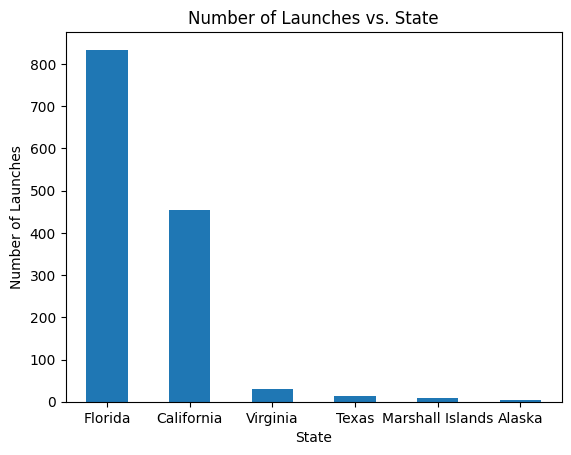

In [34]:
df_US = space[space.US_or_Not == "USA"]
a = df_US.State.value_counts()
a.plot.bar(rot=0, xlabel="State", ylabel="Number of Launches", title="Number of Launches vs. State")


In [35]:
space.Country.unique()

array([' USA', ' China', ' Kazakhstan', ' Japan', ' Israel',
       ' New Zealand', ' Russia', ' Shahrud Missile Test Site', ' France',
       ' Iran', ' India', 'USA', ' Yellow Sea', ' North Korea',
       ' Pacific Missile Range Facility', ' Pacific Ocean',
       ' South Korea', ' Barents Sea', ' Brazil', ' Gran Canaria',
       ' Kenya', ' Australia'], dtype=object)

**Some analysis on the further data. I got some feedback from my friend and he said the plot (two below) is not an accurate representation of success. Yes, Florida has had the most successful launches but we also have to take into account that Florida also had the most launches. So, I decided to go with the crosstab format because it shows the actual percentage of success and failure per launch.**

<Axes: xlabel='State'>

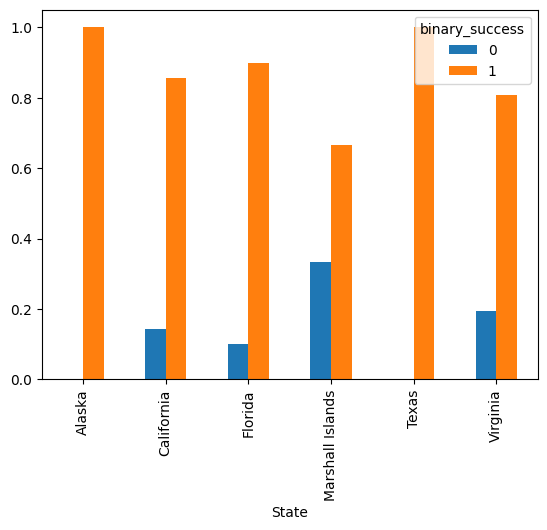

In [36]:
a = pd.crosstab(df_US.State, df_US.binary_success, normalize=True)
success_given_state = a.divide(
    a.sum(axis=1),axis=0
)
success_given_state.plot.bar()

<Axes: title={'center': 'Number of Successful Launches per State'}, xlabel='State'>

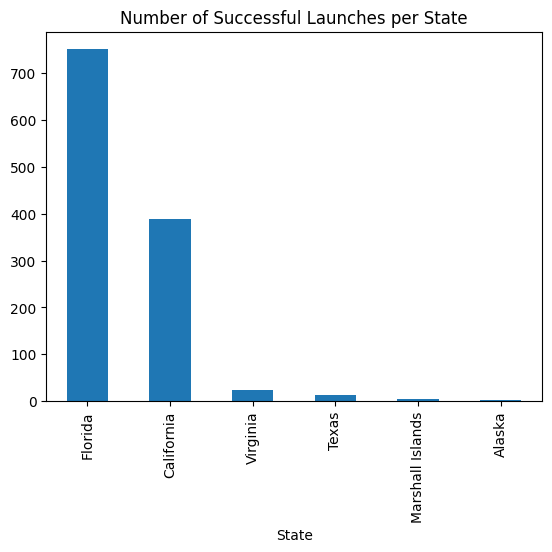

In [37]:
df_US.groupby("State")["binary_success"].sum().sort_values(ascending=False).plot.bar(title = "Number of Successful Launches per State")

In [38]:
joint_success_state = pd.crosstab(
    df_US["State"], df_US["binary_success"]
)

joint_success_state

binary_success,0,1
State,,
Alaska,0,3
California,65,389
Florida,84,750
Marshall Islands,3,6
Texas,0,13
Virginia,6,25


success given state

In [39]:
success_given_state = joint_success_state.divide(
    joint_success_state.sum(axis=1),axis=0
)
success_given_state

binary_success,0,1
State,,
Alaska,0.000000,1.000000
California,0.143172,0.856828
Florida,0.100719,0.899281
Marshall Islands,0.333333,0.666667
Texas,0.000000,1.000000
Virginia,0.193548,0.806452


<Axes: title={'center': 'Percentage of Success given State'}, xlabel='State', ylabel='Percentage of Success'>

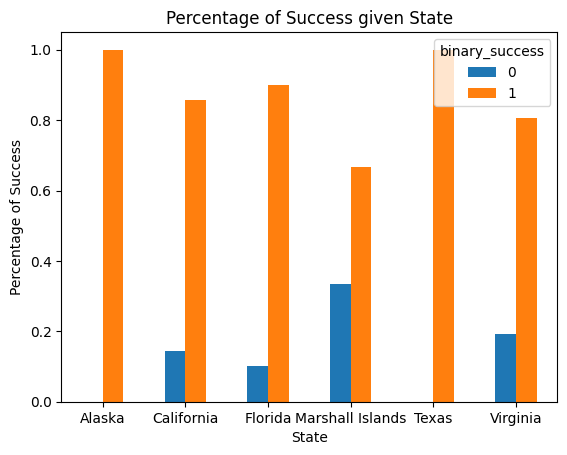

In [40]:
success_given_state.plot.bar(rot=0, ylabel="Percentage of Success", title="Percentage of Success given State")

In [41]:
px.bar(success_given_state, labels = {"State": "State", "value": "Percentage"},
       title = "Conditional Distributions for Success of a Rocket Launch given USA or not",
       category_orders={"binary_success": ["Success", "Failure"]})

In [42]:
df_US.State.unique()

array(['Florida', 'Texas', 'Virginia', 'California', 'Marshall Islands',
       'Alaska'], dtype=object)

In [43]:
df_California = df_US[df_US.State == "California"]


<Axes: xlabel='Launch Pad', ylabel='Number of Successes'>

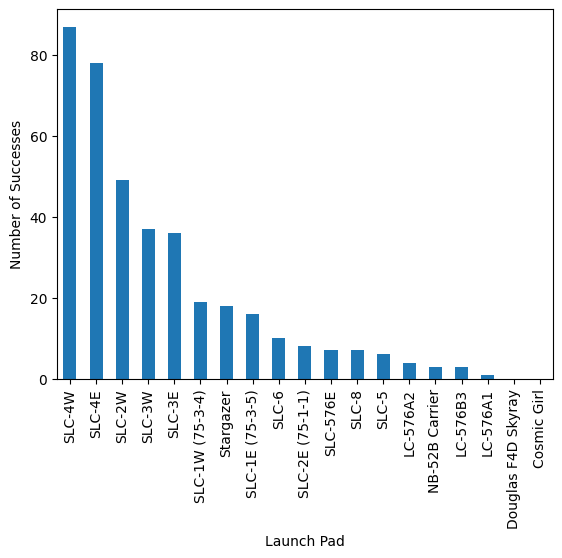

In [44]:
df_California.groupby("Launch Pad")["binary_success"].sum().sort_values(ascending=False).plot.bar(xlabel="Launch Pad", ylabel="Number of Successes")

<Axes: title={'center': 'Number of Failures for a given Launch Pad in California'}, xlabel='Launch Pad', ylabel='Number of Failures'>

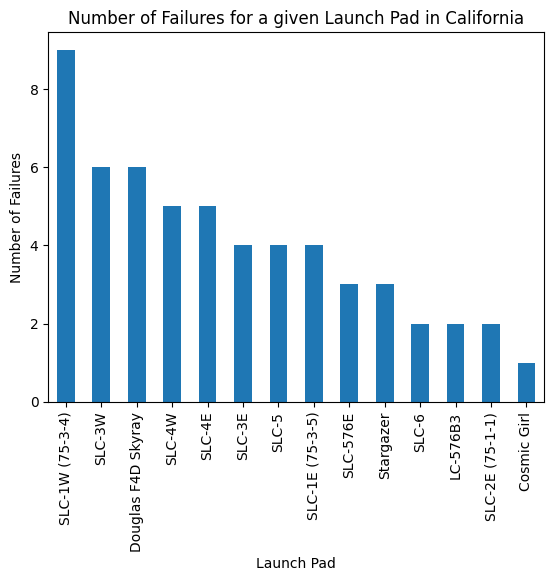

In [45]:
df_California_failures = df_California[df_California["Status Mission"] == "Failure"]
df_California_failures["Launch Pad"].value_counts().plot.bar(xlabel = "Launch Pad", ylabel="Number of Failures", title="Number of Failures for a given Launch Pad in California")

In [46]:
space.head()

,Unnamed: 0.1,Unnamed: 0,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission,Status,...,Launch Pad,Launch Center,Country,State,Vehicle,Day of the Week,Month,Day,Agency Type,Satellite Count
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success,Active,...,LC-39A,Kennedy Space Center,USA,Florida,Falcon 9 Block 5,Fri,Aug,07,Commercial,2
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success,Active,...,Site 9401 (SLS-2),Jiuquan Satellite Launch Center,China,None,Long March 2D,Thu,Aug,06,Government,2
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success,Active,...,Pad A,Boca Chica,USA,Texas,Starship Prototype,Tue,Aug,04,Commercial,1
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success,Active,...,Site 200/39,Baikonur Cosmodrome,Kazakhstan,None,Proton-M/Briz-M,Thu,Jul,30,Government,2
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success,Active,...,SLC-41,Cape Canaveral AFS,USA,Florida,Atlas V 541,Thu,Jul,30,Commercial,1


In [47]:
space["Status Mission"].value_counts()


Success              3879
Failure               339
Partial Failure       102
Prelaunch Failure       4
Name: Status Mission, dtype: int64

In [48]:
space["Day"].astype(int)

0        7
1        6
2        4
3       30
4       30
        ..
4319     5
4320     1
4321     6
4322     3
4323     4
Name: Day, Length: 4324, dtype: int64

In [49]:
import plotly.express as px
ds = space["Status Mission"].value_counts().reset_index()

ds

,index,Status Mission
0,Success,3879
1,Failure,339
2,Partial Failure,102
3,Prelaunch Failure,4


In [107]:
px.pie(ds, values = "Status Mission", names="index", title="Success vs. Failure" )

In [105]:
space["binary_success_label"] = space["binary_success"].map({0: "Failure", 1: "Success"})
p = space["binary_success_label"].value_counts().reset_index()
p
px.pie(p, values = "binary_success_label", names="index", title="Success vs. Failure")

<Axes: title={'center': 'Day vs. Satellite Count'}, xlabel='Satellite Count', ylabel='Day'>

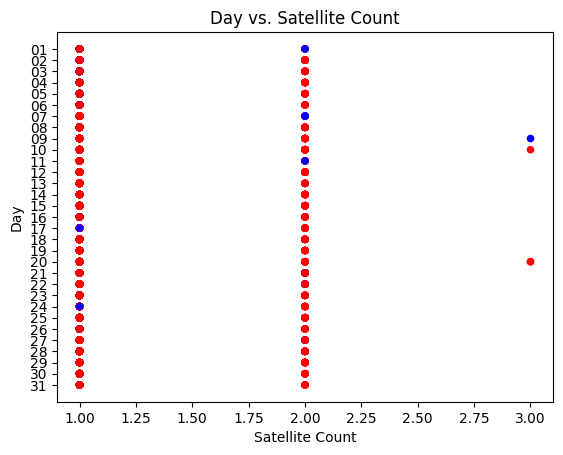

In [104]:
space_byDay = space.sort_values(by="Day", ascending=False)
colors = space["binary_success"].map({
    0: "blue",
    1: "red"
})

space_byDay.plot.scatter(
    x = "Satellite Count", y = "Day", c=colors, title = "Day vs. Satellite Count"
)

In [53]:
def successOrnot(c):
  fail = ["Failure"]
  if c in fail:
    return "Failure"
  else:
    return "Success"

space["successornot"] = space["Status Mission"].map(successOrnot)

Focusing on three features: Agency Type, Satellite Count for sake of the graph

In [111]:
colors = space["successornot"].map({
    "Success": "blue",
    "Failure": "red"
})

px.scatter(space, x="Country", y="Satellite Count", color = colors, opacity=.2, title="Satellite Count vs. Country")

In [112]:
# df_California.groupby("Launch Pad")["binary_success"].sum().sort_values(ascending=False).plot.bar(xlabel="Launch Pad", ylabel="Number of Successes")
df_success = space.groupby(['Country', "Satellite Count"])["binary_success"].sum().reset_index()
px.scatter(df_success, x = "Country", y="Satellite Count", color = "binary_success", title="Satellite Count and Country vs. Binary Success")

In [56]:
space["binary_success"].value_counts()

1    3879
0     445
Name: binary_success, dtype: int64

**Making a dataframe of failed launches. I did this so I can see what attributes can lead to a failure, used for machine learning later.**

In [57]:
failCount = space[space["binary_success_label"] == "Failure"]
failCount.reset_index().head()
failCount.shape

(445, 25)

**Percentage of success per agency type, better represented as a percentage than a count, as there are significantly more government launches.**

binary_success,0,1
Agency Type,,
Commercial,0.096795,0.903205
Government,0.106261,0.893739


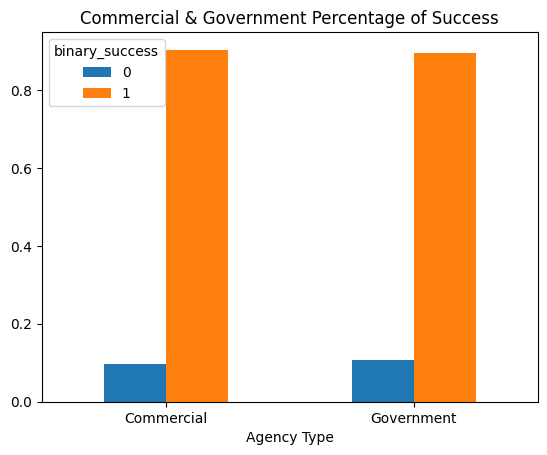

In [58]:
a = pd.crosstab(space["Agency Type"], space["binary_success"], normalize=True)
success_given_agency = a.divide(
    a.sum(axis=1),axis=0
)
success_given_agency.plot.bar(rot=0, title="Commercial & Government Percentage of Success")
success_given_agency

**Total number of launches per day of the week for both success and failures, wanted to see if there was a trend.**

<Axes: title={'center': 'Number of Launches per Day of the Week'}>

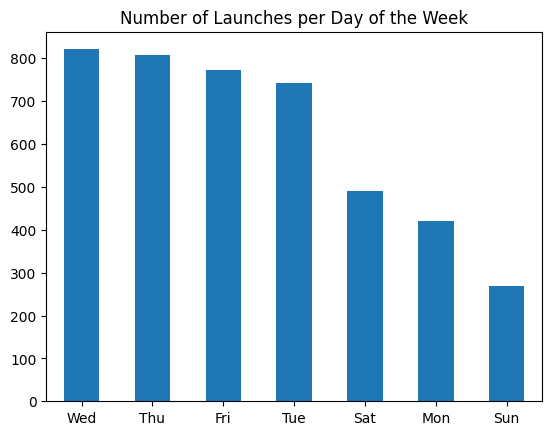

In [59]:
space["Day of the Week"].value_counts().plot.bar(rot=0, title=("Number of Launches per Day of the Week"))

**Now this is unsuccessful launches per day of the week.**



In [60]:
dayData = failCount["Day of the Week"].value_counts()
px.bar(failCount, x=dayData.index, y = dayData.values, title= "Number of Failed Launches per Day of the Week")

**Number of failed launches per month**

In [61]:
monthData = failCount["Month"].value_counts()
px.bar(failCount, x=monthData.index, y = monthData.values, title="Number of Failed Launches per month")

**Number of failed Launches per Country**

In [62]:
countryData = failCount["Country"].value_counts()
px.bar(failCount, x=countryData.index, y = countryData.values, title="Number of Failed Launches per Country")

# Actual Start of my machine learning

In [63]:
space['Country'] = space['Country'].str.strip()

**Predicting mission status by using the features, month, country, and agency type.**

In [64]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

ct = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ["Month", "Country", "Agency Type"]), remainder = "passthrough"
)

# this is my training data

xTT = space[["Month", "Country", "Agency Type", "Satellite Count"]]
yTT = space["binary_success"]

# define a pipeline
pipeline20 = make_pipeline(
    ct,
    KNeighborsClassifier(n_neighbors=2)
)

pipeline20.fit(xTT, yTT)
a = pipeline20.predict(xTT)
pd.Series(a).value_counts()

1    3815
0     509
dtype: int64

**Getting the cv_scores for my model**

In [65]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipeline20, xTT, yTT,
                            cv=10, scoring="accuracy")
cv_scores
cv_scores.mean()

0.8115147335557268

**Precision, recall, f1 score fir success and failure**

In [66]:
success = (yTT == 1)

cv_scores = cross_val_score(pipeline20, xTT, success,
                cv=10, scoring="precision")

precision_success = cv_scores.mean()
precision_success

recall_success = cross_val_score(pipeline20, xTT, success,
                cv=10, scoring="recall").mean()
recall_success
f1score_success = cross_val_score(pipeline20, xTT, success,
                cv=10, scoring="f1").mean()

precision_success, recall_success, f1score_success

(0.8964957418599067, 0.893014598151256, 0.8946016140067016)

In [67]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
failure = (yTT == 0)
precision_scorer = make_scorer(precision_score, zero_division=1)
recall_scorer = make_scorer(recall_score, zero_division=1)
f1_scorer = make_scorer(f1_score, zero_division=1)
cv_scores = cross_val_score(pipeline20, xTT, failure,
                cv=10, scoring=precision_scorer)

precision_failure = cv_scores.mean()
precision_failure

recall_failure = cross_val_score(pipeline20, xTT, failure,
                cv=10, scoring=recall_scorer).mean()
recall_failure
f1score_failure = cross_val_score(pipeline20, xTT, failure,
                cv=10, scoring="f1").mean()

precision_failure, recall_failure, f1score_failure

(0.8, 0.0, 0.0)

In [68]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    pipeline20,
    param_grid={"kneighborsclassifier__n_neighbors": range(1, 50)},
    scoring="f1_macro",
    cv=10
)

grid_search.fit(xTT, yTT)
grid_search.best_params_

{'kneighborsclassifier__n_neighbors': 2}

**Best valu for k is the one that was passed in**

In [69]:
pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,0.011868,0.002111,0.072473,0.002762,2,{'kneighborsclassifier__n_neighbors': 2},0.513811,0.507955,0.512444,0.513864,0.455107,0.474772,0.472527,0.536626,0.517561,0.457643,0.496231,0.027036,1
0,0.013788,0.002316,0.076799,0.008415,1,{'kneighborsclassifier__n_neighbors': 1},0.510381,0.487114,0.497611,0.522476,0.464474,0.467633,0.467944,0.507861,0.519531,0.465338,0.491036,0.022278,2
9,0.032352,0.023406,0.159365,0.086140,10,{'kneighborsclassifier__n_neighbors': 10},0.472594,0.494910,0.472594,0.472594,0.473171,0.473171,0.473171,0.473171,0.473171,0.472527,0.475107,0.006607,3
2,0.012634,0.002284,0.074191,0.002312,3,{'kneighborsclassifier__n_neighbors': 3},0.472594,0.490588,0.472594,0.471951,0.473171,0.472527,0.473171,0.472527,0.473171,0.471883,0.474418,0.005408,4
3,0.011939,0.000702,0.078870,0.012630,4,{'kneighborsclassifier__n_neighbors': 4},0.468059,0.486499,0.467405,0.471306,0.473171,0.472527,0.473171,0.471883,0.473171,0.471883,0.472907,0.004935,5
28,0.013098,0.003843,0.078285,0.009217,29,{'kneighborsclassifier__n_neighbors': 29},0.472594,0.472594,0.472594,0.472594,0.473171,0.473171,0.473171,0.473171,0.473171,0.472527,0.472876,0.000295,6
29,0.011193,0.000639,0.074677,0.002916,30,{'kneighborsclassifier__n_neighbors': 30},0.472594,0.472594,0.472594,0.472594,0.473171,0.473171,0.473171,0.473171,0.473171,0.472527,0.472876,0.000295,6
30,0.011527,0.001093,0.075795,0.004764,31,{'kneighborsclassifier__n_neighbors': 31},0.472594,0.472594,0.472594,0.472594,0.473171,0.473171,0.473171,0.473171,0.473171,0.472527,0.472876,0.000295,6
31,0.012647,0.000989,0.076672,0.003565,32,{'kneighborsclassifier__n_neighbors': 32},0.472594,0.472594,0.472594,0.472594,0.473171,0.473171,0.473171,0.473171,0.473171,0.472527,0.472876,0.000295,6
32,0.013202,0.001747,0.078064,0.003494,33,{'kneighborsclassifier__n_neighbors': 33},0.472594,0.472594,0.472594,0.472594,0.473171,0.473171,0.473171,0.473171,0.473171,0.472527,0.472876,0.000295,6


**Trying with new model, i could not get the cv.errors() loop to work.**

In [70]:
ct = make_column_transformer(
    (OneHotEncoder(), ["Month", "Day of the Week", "Agency Type"]), remainder = "passthrough"
)

# this is my training data

xT1 = space[["Month", "Day of the Week", "Agency Type", "Satellite Count"]]
yT1 = space["binary_success"]
pipeline0 = make_pipeline(
    ct,
    KNeighborsClassifier(n_neighbors=2)
)

pipeline0.fit(xT1, yT1)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Month', 'Day of the Week',
                                                   'Agency Type'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=2))])

In [71]:
a = pipeline0.predict(xT1)
pd.Series(a).value_counts()

1    3648
0     676
dtype: int64

In [72]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipeline0, xT1, yT1,
                            cv=10, scoring="accuracy")
cv_scores

array([0.84295612, 0.76674365, 0.78290993, 0.78060046, 0.74768519,
       0.77314815, 0.75231481, 0.7337963 , 0.77314815, 0.75925926])

In [73]:
cv_scores.mean()

0.771256201351467

**Precision, recall, and f1 scores for my model: looking at successes**

In [74]:
success = (yT1 == 1)

cv_scores = cross_val_score(pipeline0, xT1, success,
                cv=10, scoring="precision")

precision_success = cv_scores.mean()
precision_success

0.893022100699319

In [75]:
recall_success = cross_val_score(pipeline0, xT1, success,
                cv=10, scoring="recall").mean()
recall_success

0.8463471323157249

In [76]:
f1score_success = cross_val_score(pipeline0, xT1, success,
                cv=10, scoring="f1").mean()

f1score_success

0.868811052927353

**Precision, recall, and f1 scores for my model: looking at failures**

In [77]:
from sklearn.metrics import make_scorer, precision_score
failure = (yT1 == 0)
precision_scorer = make_scorer(precision_score, zero_division=1)
cv_scores = cross_val_score(pipeline0, xT1, failure,
                cv=10, scoring=precision_scorer)

precision_failure = cv_scores.mean()
precision_failure

0.4533333333333333

In [78]:
recall_scorer = make_scorer(recall_score, zero_division=1)
recall_failure = cross_val_score(pipeline0, xT1, failure,
                cv=10, scoring=recall_scorer).mean()
recall_failure

0.006717171717171717

In [79]:
f1score_failure = cross_val_score(pipeline0, xT1, failure,
                cv=10, scoring="f1").mean()

f1score_failure

0.012611111111111111

**Finding best k, using gridsearch**

In [80]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    pipeline0,
    param_grid={"kneighborsclassifier__n_neighbors": range(1, 50)},
    scoring="f1_macro",
    cv=10
)

grid_search.fit(xT1, yT1)
grid_search.best_params_

{'kneighborsclassifier__n_neighbors': 4}

In [81]:
pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3,0.012727,0.001514,0.075362,0.005276,4,{'kneighborsclassifier__n_neighbors': 4},0.484524,0.504921,0.466091,0.464771,0.469287,0.513209,0.513209,0.471883,0.494844,0.469939,0.485268,0.018701,1
0,0.013132,0.001483,0.077999,0.006987,1,{'kneighborsclassifier__n_neighbors': 1},0.484524,0.506690,0.491596,0.478687,0.475051,0.453856,0.483782,0.449682,0.519342,0.487010,0.483022,0.020040,2
1,0.013643,0.001563,0.076688,0.003825,2,{'kneighborsclassifier__n_neighbors': 2},0.509594,0.500953,0.494762,0.509158,0.453323,0.464372,0.446969,0.447404,0.497340,0.496774,0.482065,0.024560,3
2,0.012309,0.001253,0.078976,0.011375,3,{'kneighborsclassifier__n_neighbors': 3},0.487503,0.492716,0.470660,0.467405,0.473171,0.471883,0.471883,0.473171,0.495971,0.471236,0.477560,0.009804,4
7,0.013028,0.002761,0.093418,0.045865,8,{'kneighborsclassifier__n_neighbors': 8},0.490588,0.472594,0.472594,0.493804,0.473171,0.473171,0.473171,0.473171,0.473171,0.472527,0.476796,0.007738,5
5,0.017471,0.003547,0.152224,0.075885,6,{'kneighborsclassifier__n_neighbors': 6},0.490588,0.472594,0.471306,0.468712,0.472527,0.471883,0.471883,0.473171,0.495971,0.471236,0.475987,0.008804,6
6,0.018137,0.000750,0.206425,0.060742,7,{'kneighborsclassifier__n_neighbors': 7},0.490588,0.472594,0.472594,0.472594,0.473171,0.473171,0.473171,0.473171,0.473171,0.472527,0.474675,0.005312,7
4,0.011594,0.001502,0.074313,0.006752,5,{'kneighborsclassifier__n_neighbors': 5},0.490588,0.472594,0.472594,0.472594,0.472527,0.473171,0.473171,0.472527,0.473171,0.472527,0.474547,0.005354,8
9,0.011085,0.000565,0.076108,0.009486,10,{'kneighborsclassifier__n_neighbors': 10},0.490588,0.472594,0.472594,0.472594,0.471883,0.473171,0.473171,0.473171,0.473171,0.472527,0.474546,0.005362,9
35,0.012320,0.002115,0.074532,0.002086,36,{'kneighborsclassifier__n_neighbors': 36},0.472594,0.472594,0.472594,0.472594,0.473171,0.473171,0.473171,0.473171,0.473171,0.472527,0.472876,0.000295,10


**New precision and new recall for both success and failure**

In [82]:
new_precision = cross_val_score(
    grid_search.best_estimator_,
    xT1, success,
    scoring="precision",
    cv=10).mean()

new_recall = cross_val_score(
    grid_search.best_estimator_,
    xT1, success,
    scoring="recall",
    cv=10).mean()

new_precision, new_recall

(0.8973334946288993, 0.9847911505367752)

In [83]:
precision_success, recall_success

(0.893022100699319, 0.8463471323157249)

In [84]:
new_precision_failure = cross_val_score(
    grid_search.best_estimator_,
    xT1, failure,
    scoring=precision_scorer,
    cv=10).mean()

new_recall_failure = cross_val_score(
    grid_search.best_estimator_,
    xT1, failure,
    scoring=recall_scorer,
    cv=10).mean()

new_precision_failure, new_recall_failure

(0.9199999999999999, 0.0022222222222222222)

**This is the original precision and failure for model 2**

In [85]:
precision_failure, recall_failure

(0.4533333333333333, 0.006717171717171717)

In [86]:
space.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Company Name', 'Location', 'Datum',
       'Detail', 'Status Rocket', ' Rocket', 'Status Mission', 'Status',
       'US_or_Not', 'binary_success', 'failureCount', 'Launch Pad',
       'Launch Center', 'Country', 'State', 'Vehicle', 'Day of the Week',
       'Month', 'Day', 'Agency Type', 'Satellite Count',
       'binary_success_label', 'successornot'],
      dtype='object')

**Start of new model, checking how day of the week and month are related.

In [87]:
colors = space["binary_success"].map({
    0: "blue",
    1: "red"
})

px.scatter(space, x="Month", y="Day of the Week", color = colors, opacity = 0.2, title="Success/Failure of Day in the Week vs. Month")

In [88]:
ct_new = make_column_transformer(
    (OneHotEncoder(), ["Month", "Day of the Week"]), remainder = "passthrough"
)

# this is my training data

xT_new = space[["Month", "Day of the Week"]]
yT_new = space["binary_success_label"]

# define a pipeline
pipeline_new = make_pipeline(
    ct_new,
    KNeighborsClassifier(n_neighbors=2)
)

pipeline_new.fit(xT_new, yT_new)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Month',
                                                   'Day of the Week'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=2))])

In [89]:
a = pipeline_new.predict(xT_new)
pd.Series(a).value_counts()

Success    3749
Failure     575
dtype: int64

In [90]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipeline_new, xT_new, yT_new,
                            cv=10, scoring="accuracy")
cv_scores.mean()

0.7960006629030877

In [91]:
success = (yT_new == 1)
failure = (yT_new == 0)
cv_scores = cross_val_score(pipeline_new, xT_new, success,
                cv=10, scoring=precision_scorer)

precision_success = cv_scores.mean()
precision_success

recall_success = cross_val_score(pipeline_new, xT_new, success,
                cv=10, scoring=recall_scorer).mean()
recall_success
f1score_success = cross_val_score(pipeline_new, xT_new, success,
                cv=10, scoring=f1_scorer).mean()

precision_success, recall_success, f1score_success

(1.0, 1.0, 1.0)

In [92]:
cv_scores = cross_val_score(pipeline_new, xT_new, failure,
                cv=10, scoring=precision_scorer)

precision_success = cv_scores.mean()
precision_success

recall_success = cross_val_score(pipeline_new, xT_new, failure,
                cv=10, scoring=recall_scorer).mean()
recall_success
f1score_success = cross_val_score(pipeline_new, xT_new, failure,
                cv=10, scoring=f1_scorer).mean()

precision_success, recall_success, f1score_success

(1.0, 1.0, 1.0)

In [93]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    pipeline_new,
    param_grid={"kneighborsclassifier__n_neighbors": range(1, 50)},
    scoring="f1_macro",
    cv=10
)

grid_search.fit(xT_new, yT_new)
grid_search.best_params_

{'kneighborsclassifier__n_neighbors': 2}

**The number of k nearest neighbors is the same as my original model.**

# Making chloropeth plots for fun

In [113]:
import geopandas as gpd

In [114]:
import geopandas as gpd

In [94]:
countryLst = ["Russia", "USA", "Kazakhstan", "France", "China", "Japan", "India", "Pacific Ocean", "New Zealand", "Iran", "Israel", "Kenya", "Australia", "North Korea", "South Korea", "Brazil"]
freq = [1395, 1344, 701, 303, 268, 126, 76, 36,13,13,11,9,6,5,3]
data = {'Country' : ["Russia", "United States of America", "Kazakhstan", "France", "China", "Japan", "India", "Pacific Ocean", "New Zealand", "Iran", "Israel", "Kenya", "Australia", "North Korea", "South Korea", "Brazil"],
        'freq': [1395, 1344, 701, 303, 268, 126, 76, 36, 13, 13, 11, 9, 6, 5, 3, 3]}
df1 = pd.DataFrame(data)

In [99]:
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
world.head()

<ipython-input-99-794e9e622c9b>:1: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [100]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the GeoDataFrame with your DataFrame
geo_df = world.merge(df1, how='left', left_on='name', right_on='Country') #match the country w iso3 in new df

# Create the choropleth map using Plotly Express
fig = px.choropleth(
    geo_df,
    locations='iso_a3',  # for natrualearth_lowres there are iso_a3 which are the code names and name which is the actual name
    color='freq',
    color_continuous_scale='sunset',
    projection='natural earth',
    title='Choropleth Map of Number of Launches'
)


# Show the map
fig.show()

<ipython-input-100-222bbeb83844>:1: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



In [103]:
df_rockets.head()

,Rocket Name,Missions,Successes,Partial Failures,Failures,Success Streak,Success Rate,Accurate Success Rate,Failure Rate,Total Failures
0,Alpha,3,1,1,1,1,50.0%,33.333333,0.666667,2
1,Amur,0,0,0,0,0,0,0.000000,0.000000,0
2,Angara 1,3,3,0,0,3,100%,100.000000,0.000000,0
3,Angara A5,3,2,0,1,0,66.7%,66.666667,0.333333,1
4,Antares,18,17,0,1,13,94.4%,94.444444,0.055556,1


File ‘colab_pdf.py’ already there; not retrieving.

Mounted at /content/drive/


ValueError: ignored